In [1]:
%matplotlib notebook

After collecting the frame, how long does it take for the software to identify the animal, calculate the stimulus that needs to be presented and receive the next frame? To make this realistic I used a fly and presented it with a checkerboard virtual reality. The measurements should therefore be very conservative as in a real experiment the CPU is used less (due to the time.time() call here)

### Important: There are two different clocks that can be used:

1) python internal time.time(). This clock is a python function and therefore 'asks' the CPU for the time. The CPU of course is a multipurpose instrument and does much more than listen to python and giving the time. Measuring with the time.time() function therefore is relatively inprecise (probably 100s of us, maybe ms). However, this is the best measurement for image processing time I was able to find.

2) The camera clock: The CCD camera does very little besides counting time as it needs to keep track on how long each line on the sensor has been collecting photons. The clock is therefore very precise. If it were not we would see image distortions. Thankfully, each image also gets a timestamp from the camera (Actually it could also be that the timestamps comes from  the GPU - but this would also from be a real-time system, so it wouldn't change the argument). I therefore consider the timestamp from the camera to be representing 'real-time'. Also check this resource (the API of the PiCamera Python wrapper): https://picamera.readthedocs.io/en/latest/fov.html#division-of-labor While this method is more precise, it does NOT allow the measurement of the image processing time. It only allows for checking if frames were skipped.

Regarding Point 1:

To measure this, the time was measured BEFORE the image data is taken from the buffer, rearranged to the image and the animal identified and stimulus calculated. The time was measured again when this was done. The function I used is the built in time.time().

I was unable to find measurements for how precise time.time() is using python 3.6. I have to run a measurement on the RPi I used to measure this, but it's probably in the 100s of us to ~ms.

Pseudocode of measurement:

    buffer = grab_frame

    start = time.time()

    image = rearrange(buffer)

    animal_position = identify_animal(image)

    stimulus = calc_stim(animal_position)

    end = time.time()

    buffer = grab_frame....

NOTE: The data collected on the morning of the 17th of July has a funny format - the times are not aligned in
the numpy file! The reason is the following:

    looptime[i_tracking] = time.time()

    do stuff

    i_tracking +=1 

    looptime[i_tracking] = time.time()


Corrected it in the PiVR software!

In [2]:
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
from glob import glob
from pathlib import Path

In [3]:
home_path = os.getcwd()

In [4]:
data_path = Path(str(home_path),'data/benchmarking/loop_time/')
# all the figures will be saved in this folder
target_path = Path(str(home_path),'plots/Fig1S1/')
os.makedirs(target_path, exist_ok=True)

In [5]:
def get_camera_time():
    '''
    Get the "real" time by reading the timestamps of the frames by the camera:
    '''
    # get the expected framerate
    with open('experiment_settings.json') as json_data:
        experiment_data = json.load(json_data)
    expected_framerate = experiment_data['Framerate']
    # 1/fps is the time we expect frames to differ between each other
    expected_time_taken = 1/expected_framerate
    # get the csv file with the timestamps of the camera
    files = [p.replace('\\', '') for p in glob('*')]
    for file in files:
        if 'data.csv' in file:
            data = pd.read_csv(file)

    # create array for the difference between each timepoints
    time_taken = data['Time'].diff(periods=1)
    # only care about frames actually taken
    # At start: First two are always zero. Either true or a bug in the firmware
    # ignore the very first one - can't be true!
    first_relevant_index = np.nonzero(data['Time'])[0][0]
    last_relevant_index = np.nonzero(data['Time'])[0][-2]

    time_taken_ms = time_taken[first_relevant_index:last_relevant_index] / 1000
    expected_time_taken_ms30 = expected_time_taken / 1000
    
    return(time_taken_ms)

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


<IPython.core.display.Javascript object>


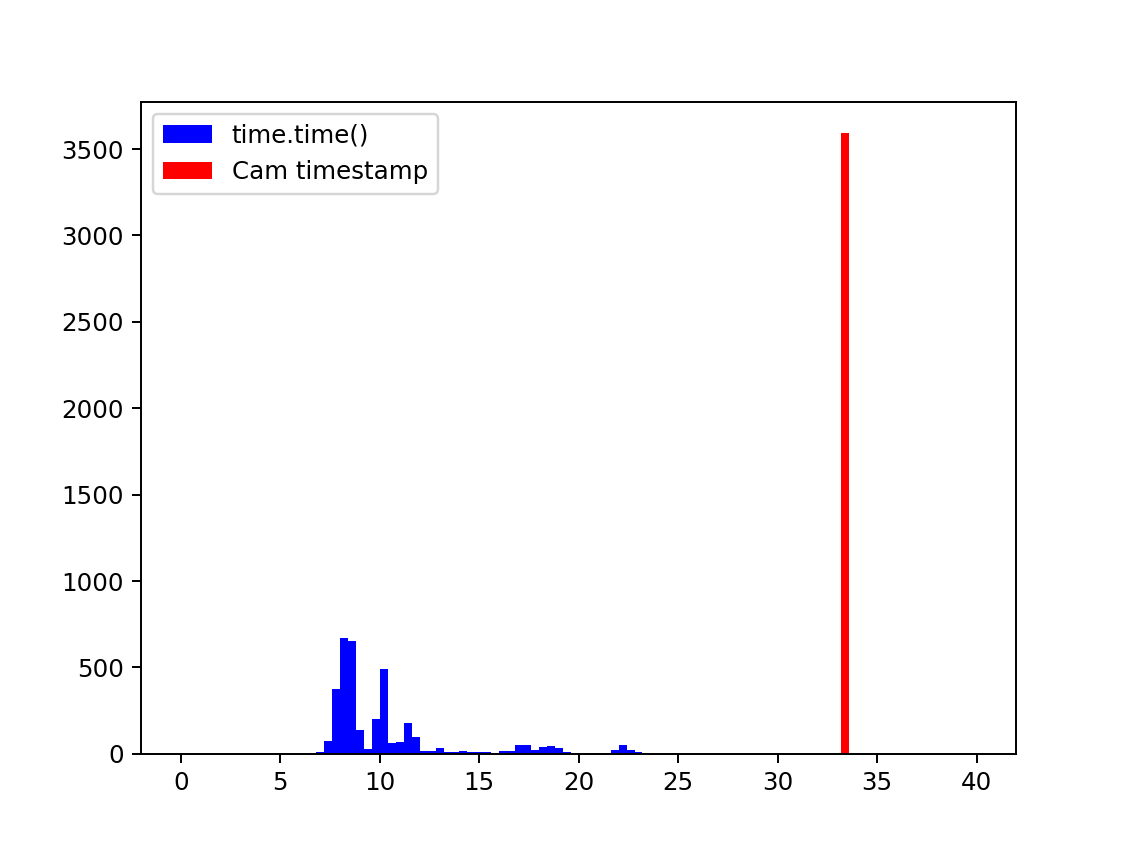

In [6]:
# 30fps case
current_data_path = Path(str(data_path), "2019.06.17_10-48-16_loop_time_30fps/")
os.chdir(current_data_path)
# Get the real timestamps of the frames by the camera  
time_taken_ms_30fps = get_camera_time()

# get the loop timestamps (system time, got it with time.time())
loop_timestamps = np.load('loop_time.npy')
# need to correct the misaligned array by shifting the timestamps once "to the left" (-1)
corrected_loop_timestamp_after = np.roll(loop_timestamps[:,1], -1)
time_diff = corrected_loop_timestamp_after[1:-1] - loop_timestamps[1:-1,0]
time_diff_ms_30fps = time_diff * 1000

fig = plt.figure()
ax = fig.add_subplot(111)
y_values, bin_edges, _ = ax.hist(time_diff_ms_30fps, bins=100, range=(0,40), color='b', label='time.time()')
y_values, bin_edges, _ = ax.hist(time_taken_ms_30fps, bins=100, range=(0,40), color='r', label='Cam timestamp')
ax.legend()

<IPython.core.display.Javascript object>


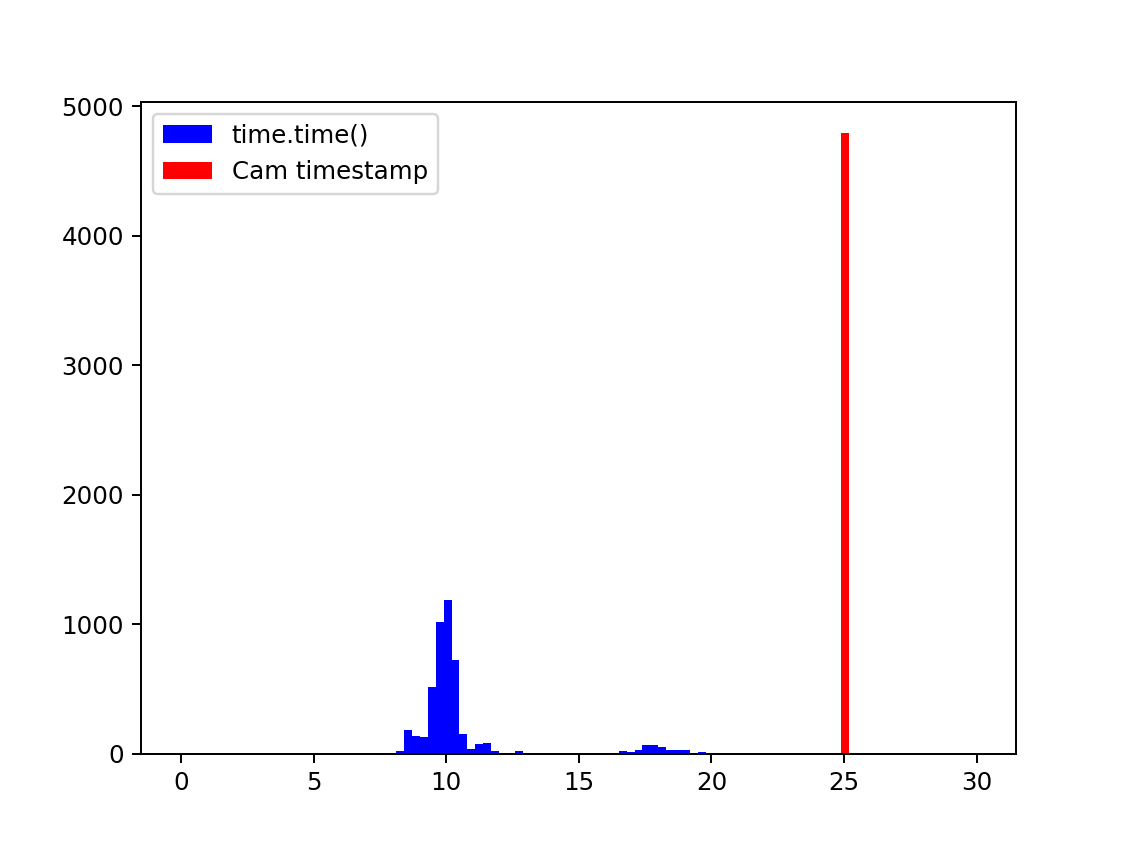

In [7]:
# 40fps case
current_data_path = Path(str(data_path), "2019.06.17_10-50-39_loop_time_40fps/")
os.chdir(current_data_path)
# Get the real timestamps of the frames by the camera  
time_taken_ms_40fps =get_camera_time()


loop_timestamps = np.load('loop_time.npy')
# need to correct the misaligned array
corrected_loop_timestamp_after = np.roll(loop_timestamps[:,1], -1)
time_diff = corrected_loop_timestamp_after[1:-1] - loop_timestamps[1:-1,0]
time_diff_ms_40fps = time_diff * 1000

fig = plt.figure()
ax = fig.add_subplot(111)
y_values, bin_edges, _ = ax.hist(time_diff_ms_40fps, bins=100, range=(0,30), color='b', label='time.time()')
y_values, bin_edges, _ = ax.hist(time_taken_ms_40fps, bins=100, range=(0,30), color='r', label='Cam timestamp')
ax.legend()

<IPython.core.display.Javascript object>


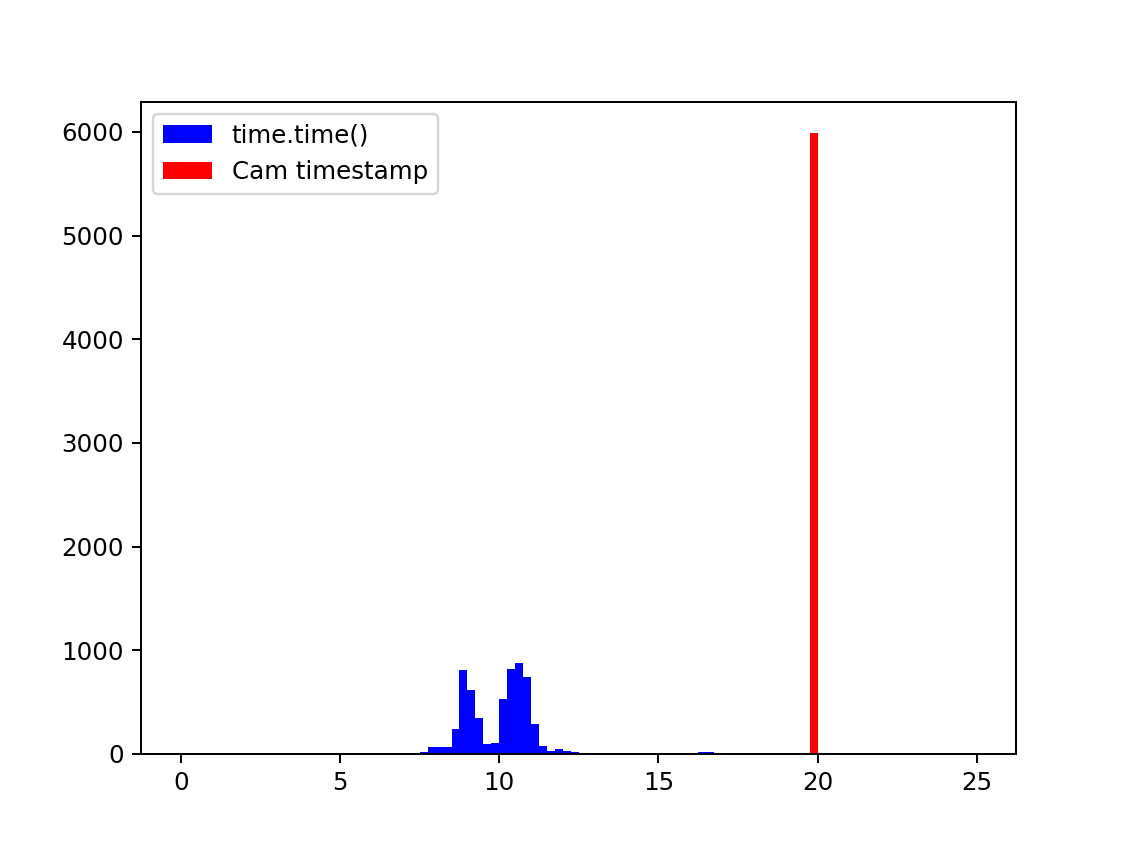

In [8]:
# 50fps case
current_data_path = Path(str(data_path), "2019.06.17_10-53-26_loop_time_50fps/")
os.chdir(current_data_path)
# Get the real timestamps of the frames by the camera  
time_taken_ms_50fps =get_camera_time()


loop_timestamps = np.load('loop_time.npy')
# need to correct the misaligned array
corrected_loop_timestamp_after = np.roll(loop_timestamps[:,1], -1)
time_diff = corrected_loop_timestamp_after[1:-1] - loop_timestamps[1:-1,0]
time_diff_ms_50fps = time_diff * 1000

fig = plt.figure()
ax = fig.add_subplot(111)
y_values, bin_edges, _ = ax.hist(time_diff_ms_50fps, bins=100, range=(0,25), color='b', label='time.time()')
y_values, bin_edges, _ = ax.hist(time_taken_ms_50fps, bins=100, range=(0,25), color='r', label='Cam timestamp')
ax.legend()

<IPython.core.display.Javascript object>


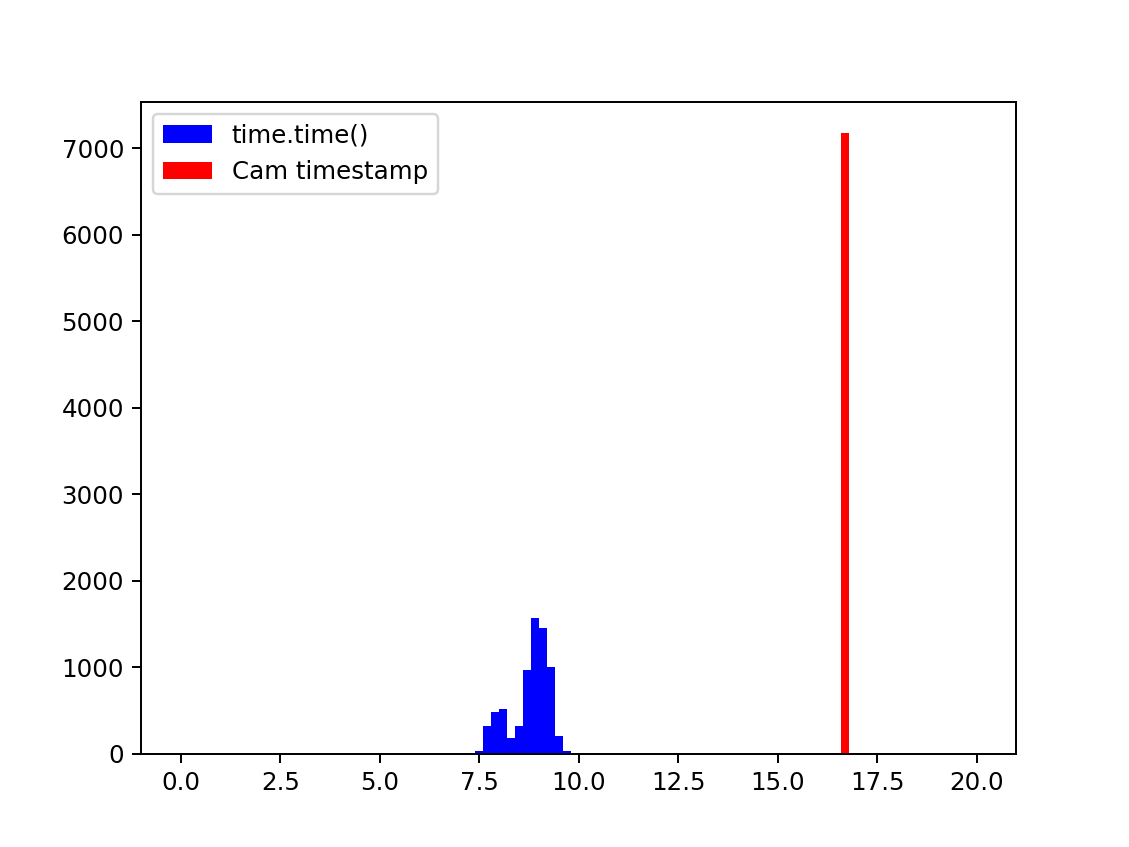

In [9]:
# 60fps case
current_data_path = Path(str(data_path), "2019.06.17_11-06-22_loop_time_60fps/")
os.chdir(current_data_path)
# Get the real timestamps of the frames by the camera  
time_taken_ms_60fps =get_camera_time()


loop_timestamps = np.load('loop_time.npy')
# need to correct the misaligned array
corrected_loop_timestamp_after = np.roll(loop_timestamps[:,1], -1)
time_diff = corrected_loop_timestamp_after[1:-1] - loop_timestamps[1:-1,0]
time_diff_ms_60fps = time_diff * 1000

fig = plt.figure()
ax = fig.add_subplot(111)
y_values, bin_edges, _ = ax.hist(time_diff_ms_60fps, bins=100, range=(0,20), color='b', label='time.time()')
y_values, bin_edges, _ = ax.hist(time_taken_ms_60fps, bins=100, range=(0,20), color='r', label='Cam timestamp')
ax.legend()

<IPython.core.display.Javascript object>


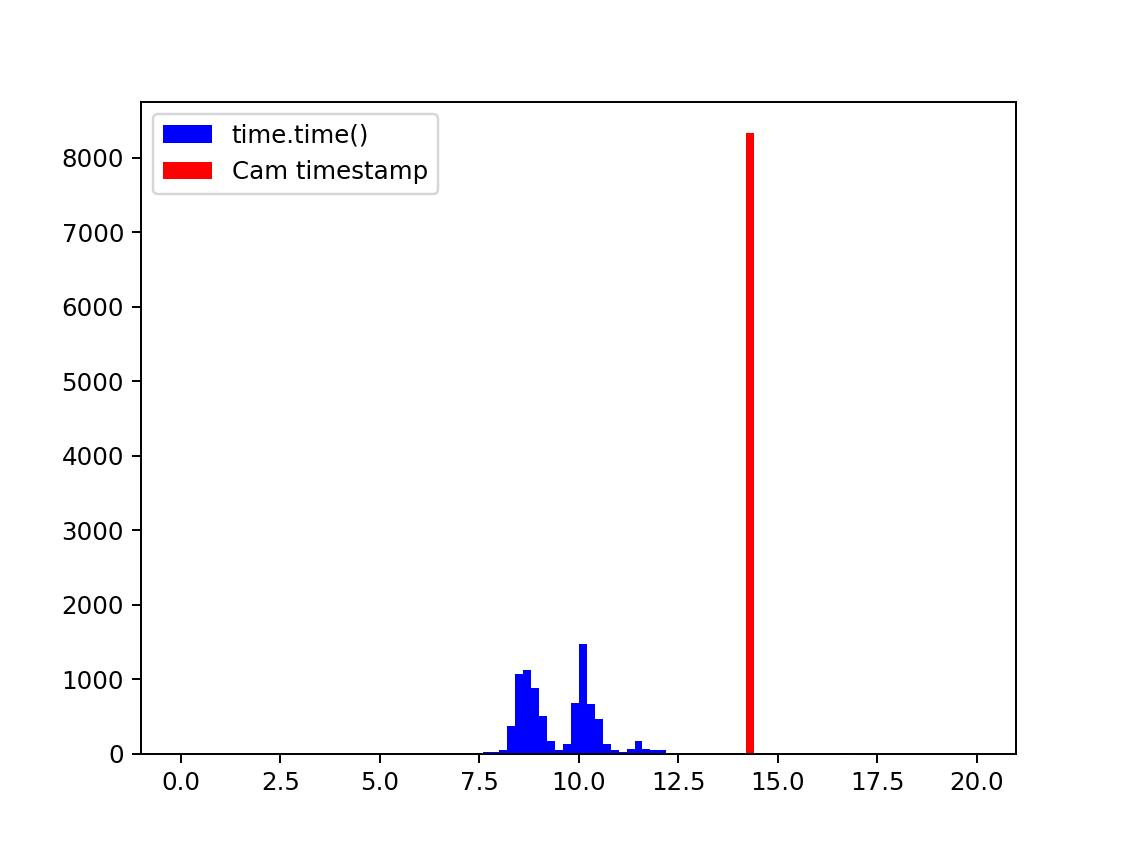

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [10]:
# 70fps case
current_data_path = Path(str(data_path), "2019.06.17_11-08-42_loop_time_70fps/")
os.chdir(current_data_path)
# Get the real timestamps of the frames by the camera  
time_taken_ms_70fps =get_camera_time()

loop_timestamps = np.load('loop_time.npy')
# need to correct the misaligned array
corrected_loop_timestamp_after = np.roll(loop_timestamps[:,1], -1)
time_diff = corrected_loop_timestamp_after[1:-1] - loop_timestamps[1:-1,0]
time_diff_ms_70fps = time_diff * 1000

fig = plt.figure()
ax = fig.add_subplot(111)
y_values, bin_edges, _ = ax.hist(time_diff_ms_70fps, bins=100, range=(0,20), color='b', label='time.time()')
y_values, bin_edges, _ = ax.hist(time_taken_ms_70fps, bins=100, range=(0,20), color='r', label='Cam timestamp')
ax.legend()

<IPython.core.display.Javascript object>


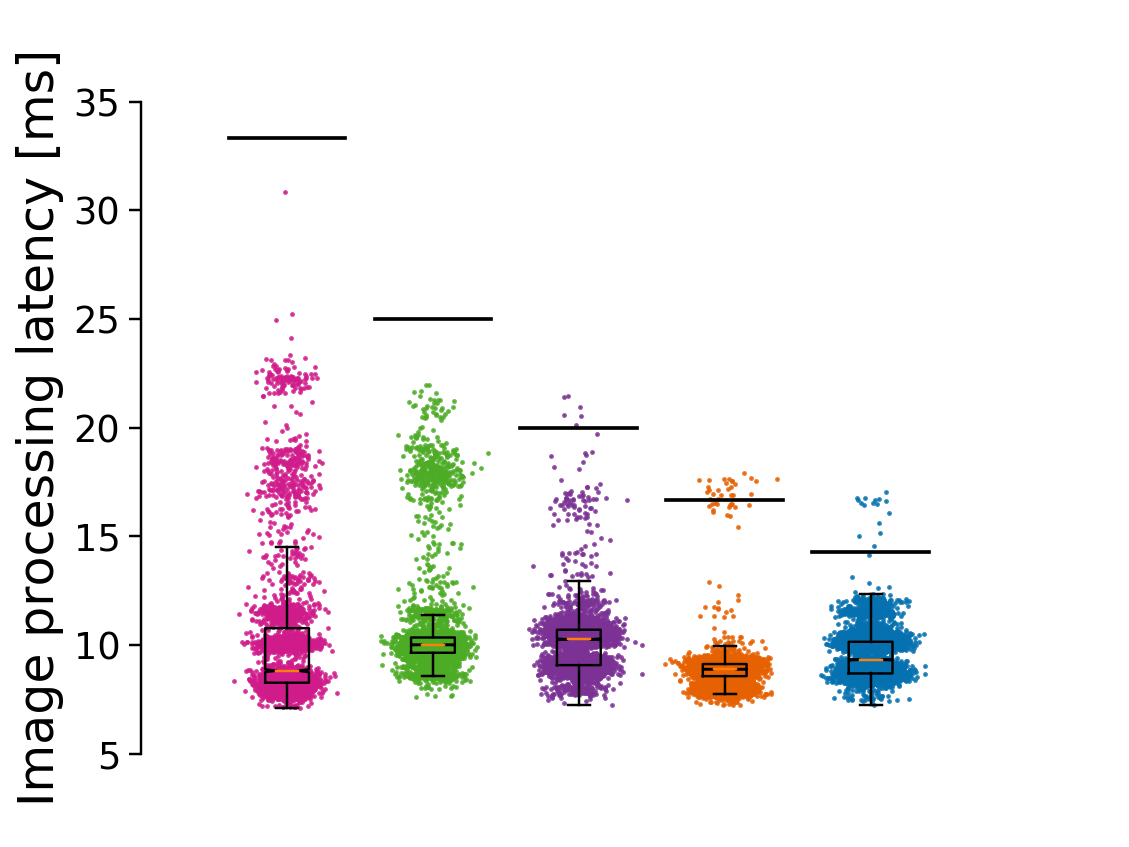

In [11]:
# Plot cycle time...best using boxplot with scatterplot...

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_rasterization_zorder(1)
def boxplot_and_scatter(x_position, y_data,color, fps=None, boxplot=False):
    x_jittered = np.random.normal(x_position, 0.05, size=y_data.shape[0])
    ax.scatter(x=x_jittered, y=y_data, alpha=0.8, color=color, zorder=0,s=1)
    if boxplot:
        ax.boxplot(y_data, showfliers=False, positions=[x_position],notch=True,zorder=1)
    # plot the line indicating the maximum allowed loop time
    if fps is not None:
        ax.plot([x_position-0.2,x_position+0.2], [1/fps*1000, 1/fps*1000], c='k')

# plot single points for each dataset
boxplot_and_scatter(0, time_diff_ms_30fps[~np.isnan(time_diff_ms_30fps)],color='#d01c8b',fps=30,boxplot=True)
boxplot_and_scatter(0.5, time_diff_ms_40fps[~np.isnan(time_diff_ms_40fps)],color='#4dac26',fps=40,boxplot=True)
boxplot_and_scatter(1, time_diff_ms_50fps[~np.isnan(time_diff_ms_50fps)],color='#7b3294',fps=50,boxplot=True)
boxplot_and_scatter(1.5, time_diff_ms_60fps[~np.isnan(time_diff_ms_60fps)],color='#e66101',fps=60,boxplot=True)
boxplot_and_scatter(2, time_diff_ms_70fps[~np.isnan(time_diff_ms_70fps)],color='#0571b0',fps=70,boxplot=True)

#ax.set_xticklabels(['Light On','Light Off','Light On','Light Off'], fontsize=22, rotation=60)
ax.set_xticklabels([])
ax.set_ylabel('Image processing latency [ms]', fontsize=20)

ax.set_ylim(5,35)
#ax.grid(alpha=0.5, axis='y')

# extend x axis to make space for legend
ax.set_xlim(-0.5,2.5)

# get rid of ticks (bottom ticks)
ax.tick_params(
        #axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the left edge are off
        labelleft=True,   # labels along the left edge are off
        labelbottom=True
        ) 

# turn spines of everywhere except on the left
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1)
# modify spines on the left
ax.spines['left'].set_bounds(5,35)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=1, length =5)
#ax.tick_params(axis='both', which='minor', width =2,length =3)
ax.tick_params(axis='y', labelsize=15)

# To save image, uncomment the line below
# fig.savefig(Path(str(target_path),'fig1S1ci.eps'), rasterized=True, dpi=300)

<IPython.core.display.Javascript object>


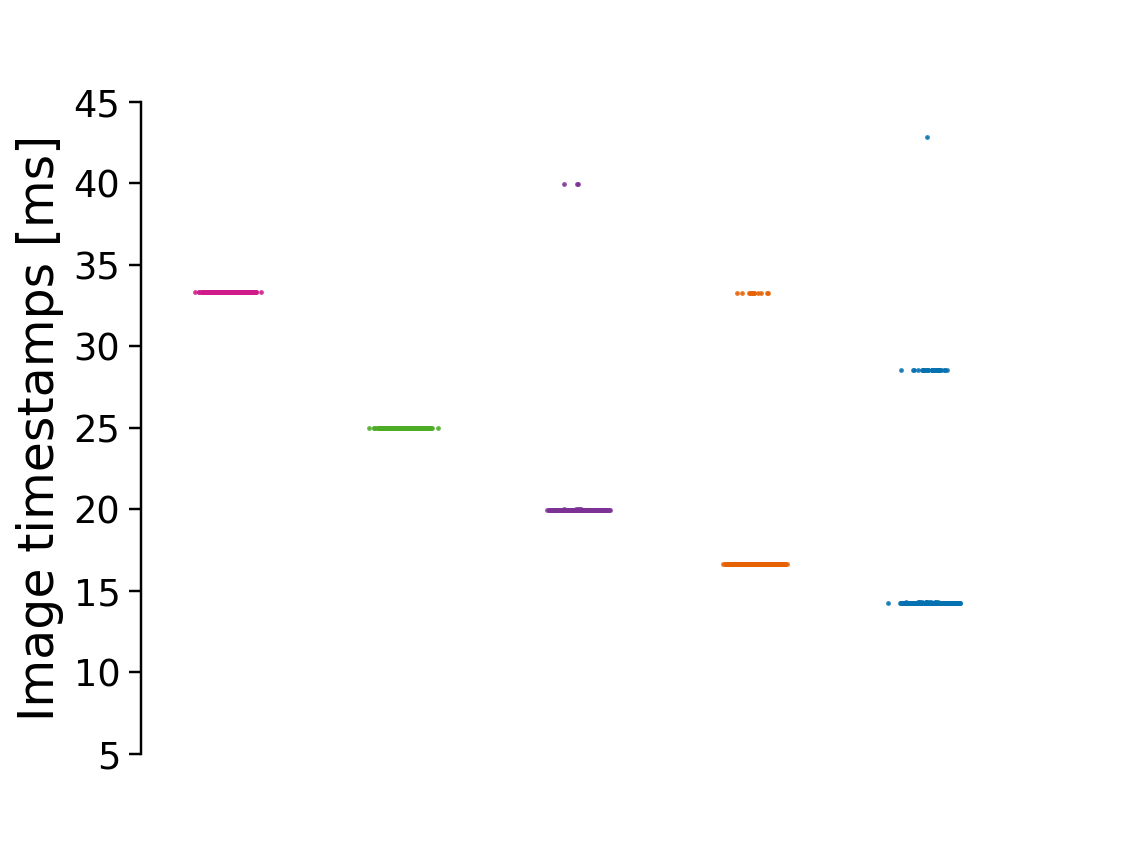

In [12]:
time_taken_ms_30fps

fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_rasterization_zorder(1)

boxplot_and_scatter(0, time_taken_ms_30fps[~np.isnan(time_taken_ms_30fps)],color='#d01c8b')
boxplot_and_scatter(1, time_taken_ms_40fps[~np.isnan(time_taken_ms_40fps)],color='#4dac26')
boxplot_and_scatter(2, time_taken_ms_50fps[~np.isnan(time_taken_ms_50fps)],color='#7b3294')
boxplot_and_scatter(3, time_taken_ms_60fps[~np.isnan(time_taken_ms_60fps)],color='#e66101')
boxplot_and_scatter(4, time_taken_ms_70fps[~np.isnan(time_taken_ms_70fps)],color='#0571b0')

ax.set_xticklabels([])
ax.set_ylabel('Image timestamps [ms]', fontsize=20)

ax.set_ylim(5,45)
#ax.grid(alpha=0.5, axis='y')

# extend x axis to make space for legend
ax.set_xlim(-0.5,4.5)

# get rid of ticks (bottom ticks)
ax.tick_params(
        #axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the left edge are off
        labelleft=True,   # labels along the left edge are off
        labelbottom=True
        ) 

# turn spines of everywhere except on the left
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1)
# modify spines on the left
ax.spines['left'].set_bounds(5,45)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=1, length =5)
#ax.tick_params(axis='both', which='minor', width =2,length =3)
ax.tick_params(axis='y', labelsize=15)

# To save image, uncomment the line below
# fig.savefig(Path(str(target_path),'fig1S1cii.eps'), rasterized=True, dpi=300)